# Time Transformer [`t2`] (mini) Analysis Pipeline

### Time Transformer Analysis Pipeline

Time Transformer is an attempt to apply the transformer architecture to time series. In this walk through I will use the **WISDM** (**WI**reless **S**ensor **D**ata **M**ining dataset: http://www.cis.fordham.edu/wisdm/includes/files/sensorKDD-2010.pdf)
    

In late 2019, an [updated **WISDM** dataset](https://archive.ics.uci.edu/ml/datasets/WISDM+Smartphone+and+Smartwatch+Activity+and+Biometrics+Dataset+) was release which included 18 categories with many more observations. It is a big imporovement on the previous dataset, with balanced class distributions shown in table 4 of the [paper](https://archive.ics.uci.edu/ml/machine-learning-databases/00507/WISDM-dataset-description.pdf). We shall explore both datasets in this notebook

The motivation for using this dataset is for multivariate time series classification, which is exactly the problem we are trying to solve for Type Ia Supernova. With Supernova classification we have observations accross 6 passbands for "each timestep". 

There is a ***disclaimer*** is since we don't _actually_ have measurements for all 6 'variables' for everytime step, but this can be resolved with a Gaussian Process regression for interpoloation of points between actual observed data.

Therefore we will use this dataset as a proof on concept to see if this type of architecture would be suitable for our problem too.

As mentioned in the [WISDM website](http://www.cis.fordham.edu/wisdm/dataset.php) the dataset can be describes as follows:
    
**Raw Time Series Data**
- Number of examples: 1,098,207
- Number of attributes: 6
- Missing attribute values: None

**Class Distribution**
- Walking: 424,400 (38.6%)
- Jogging: 342,177 (31.2%)
- Upstairs: 122,869 (11.2%)
- Downstairs: 100,427 (9.1%)
- Sitting: 59,939 (5.5%)
- Standing: 48,395 (4.4%)

Below is a short video showing how data of this type is collected:

In [9]:
from IPython.display import HTML

HTML('<center><iframe width="560" height="315" src="https://www.youtube.com/embed/XOEN9W05_4A" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></center>')

The purpose of this notebook is to walk through the `t2` analysis pipeline step-by-step, using the **WISDM** data as a showcase for multivariate time series classification.

This notebook also uses `nbval` to evaluate cells for a continuous integration test of this "mini" pipeline 

## Table of Contents

#### Notebook Imports

In [92]:
import argparse
import joblib
import json
import logging
import numpy as np
import subprocess
import sys
import tensorflow as tf
import time

from pathlib import Path
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorboard.plugins.hparams import api as hp
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.backend import clear_session

#### `astronet` Folder Structure

The `astronet.t2` folder structure looks like so:

In [11]:
!tree -I '*.pdf|__pycache__|tests|*.pkl|model-*' -L 2 ../astronet/t2/

../astronet/t2/
├── attention.py
├── evaluate.py
├── model.py
├── models
│   ├── plasticc
│   ├── spcc
│   ├── wisdm_2010
│   └── wisdm_2019
├── multihead_attention.py
├── opt
│   ├── hypertrain.py
│   ├── optimise.py
│   ├── runs
│   ├── somefile.py
│   └── studies.log
├── plots
│   ├── plasticc
│   ├── spcc
│   ├── wisdm_2010
│   └── wisdm_2019
├── preprocess.py
├── studies.log
├── train.py
├── transformer.py
├── utils.py
└── visuals.py

12 directories, 14 files


They key files we will look at here are:

   * `model.py`
   * `attention.py`
   * `opt/hypertrain.py`
   * `train.py`
   * `evaluate.py`
   * `visuals.py`

## The Model

First let's understand the model that has been developed.

### What is the Transformer achitecture?

The overall architecture of the Transformer network can be seen below. It consists of the _encoder_ section and a _decoder_ section

<img src="./images/transformer-arch.png" height=40% width=40%>

In the first instance, we will implement just the _encoder_ section show here and add a softmax output:

<img src="./images/transformer-arch-encoder.png" height=30% width=30%>

Depending on results and if we are able to get the inputs to behave, we will move towards development and analysis of the full Transformer architecture for time series. However, so far, just the encoder section seems to give sufficent results (more discussed later)

A key aspect of the Transformer achitecutre, whic hfeatures in both the encoder and decoder sections, is the "multi-headed attention block"

For details see the blog post: [The llustrated Transformer](http://jalammar.github.io/illustrated-transformer/)

But this can be seen pictorially as follows:
<img src="./images/transformer-arch-multihead.png" height=30% width=30%>

## Adapting the Transformer for Time-Series

The Transformer architeecture was originally applied to NLP tasks of translation. For this, there were specific stages in the pipeline that are focused towards working with words. For example, the embedding layer would project each word into a high-dimensional vector space followed by a positional enciding layer to ensure sequential information is preversed.

In the case of time-series, a simple Dese layer can be used to map the (`m, T, 6`)(batch, time-steps, features) into a (`m, 32`)(batch, time-steps x features). In `keras`, in order to apply a Dense layer to each input in the time sequence, there is `TimeDistributed` layer.  

From "Hands-On Machine Learning" by Aurelien Geron

> The `TimeDistributed` layer wraps any layer (e.g. `Dense` layer) and applies it at every time step of its input sequence. It does this efficiently, by reshaping the inputs so that each time step is treated as a seperate instance ( i.e, it reshapes the inputs from [*batch size, time-steps, input dimension*] to [*batch size x time-steps, input dimensions].

...
> The `Dense` layer actually supports sequences as inputs (and even higher dimensional inputs): it handles them just like `TimeDistributed(Dense(...))`, meaning it is applied to the last input dimension only (independently accross all time steps). Thus, we could just replace ... with just `Dense(..)`

> Note that a `TimeDistributed(Dense(n))` layer is equivalent to a `Conv1D(n, filter_size=1)` layer.

* https://keras.io/api/layers/convolution_layers/convolution1d/
* https://keras.io/api/layers/recurrent_layers/time_distributed/

##### But what is a 1-D convolition I hear you cry!?

In [12]:
from IPython.display import HTML

HTML('<center><iframe width="560" height="315" src="https://www.youtube.com/embed/vcp0XvDAX68" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></center>')

In [ ]:
# %load -r 1-40 ../astronet/t2/model.py
from tensorflow import keras
from tensorflow.keras import layers

from astronet.t2.transformer import ConvEmbedding, TransformerBlock


class T2Model(keras.Model):
    """Time-Transformer with Multi-headed.
    embed_dim --> Embedding size for each token
    num_heads --> Number of attention heads
    ff_dim    --> Hidden layer size in feed forward network inside transformer
    """
    def __init__(self, input_dim, embed_dim, num_heads, ff_dim, num_filters, num_classes, **kwargs):
        super(T2Model, self).__init__()
        self.input_dim      = input_dim
        self.embed_dim      = embed_dim
        self.num_heads      = num_heads
        self.ff_dim         = ff_dim
        self.num_filters    = num_filters
        self.num_classes    = num_classes

        self.embedding      = ConvEmbedding(num_filters=self.num_filters, input_shape=input_dim[1:])
        self.encoder        = TransformerBlock(self.embed_dim, self.num_heads, self.ff_dim)
        self.pooling        = layers.GlobalAveragePooling1D()
        self.dropout1       = layers.Dropout(0.1)
        self.fc             = layers.Dense(20, activation="relu")
        self.dropout2       = layers.Dropout(0.1)
        self.classifier     = layers.Dense(self.num_classes, activation="softmax")

    def call(self, inputs, training=False):

        embedding   = self.embedding(inputs)
        encoder     = self.encoder(embedding)
        pooling     = self.pooling(encoder)
        dropout1    = self.dropout1(pooling)
        fc          = self.fc(dropout1)
        dropout2    = self.dropout2(fc)
        classifier  = self.classifier(dropout2)

        return classifier

Where `ConvEmbedding` and `TransformerBlock` are defined in `transformer.py` shown below:

In [ ]:
# %load -r 1-42 ../astronet/t2/transformer.py
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from astronet.t2.attention import MultiHeadSelfAttention


class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [
                layers.Dense(ff_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class ConvEmbedding(layers.Layer):
    def __init__(self, num_filters, **kwargs):
        super(ConvEmbedding, self).__init__(**kwargs)
        self.conv1d = layers.Conv1D(
            filters=num_filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        embedding = self.conv1d(inputs)

        return embedding

For brevity, I have left out the implementation for `MultiHeadSelfAttention(embed_dim, num_heads)` but for details see `attention.py`

## Training

### Hyperparameter Optimisation with `t2/opt/hypertrain.py`

In [70]:
__file__ = f"{Path().resolve().parent}/astronet/t2/opt/hypertrain.py"

Now that there is a model defined, and we know the data we shall be using to evaluate, we can now start to train this model.

To begin, it is often the case one trains for a short period of time on using various paramteres to determine which _hyperparameters_ one should use when fully training.

To do this, we have `opt/hypertrain.py` which uses [Optuna](https://optuna.org/) for hyperparamter optimisation, and specifically, **Bayesian Optimisation** using the Tree-structured Parzen Estimator (TPE) algorithm

For further information about TPE algorithm, please refer to the following papers:

[Algorithms for Hyper-Parameter Optimization](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf)

[Making a Science of Model Search: Hyperparameter Optimization in Hundreds of Dimensions for Vision Architectures](http://proceedings.mlr.press/v28/bergstra13.pdf)

Having a peek inside `opt/hypertrain.py` shows the parameter space we are exploring:

In [ ]:
# %load -r 82-84 ../astronet/t2/opt/hypertrain.py
embed_dim = trial.suggest_categorical("embed_dim", [32, 64, 128, 512])  # --> Embedding size for each token
num_heads = trial.suggest_categorical("num_heads", [4, 8, 16])  # --> Number of attention heads
ff_dim = trial.suggest_categorical("ff_dim", [32, 64, 128, 512])  # --> Hidden layer size in feed forward network inside transformer

To begin hyperparameter optimisation, first we decide which dataset we want to evaluate.

There are two functions currently in `astronet/t2/utils.py` that are helper functions for loading in the desired data.

1. `load_wisdm_2010()`
2. `load_wisdm_2019()`

Which can be accessed using command line arguments such as: `python opt/hypertrain.py --dataset "wisdm_2010"`

The results from running the above is a `runs/<dataset>/study-<name>.pkl` is saved to disk for inspection later. We will look at this now.

For this notebook, we will define which dataset in a variable, and work with snippets in each file as opposed to running the complete files.

See `astronet/t2/utils.py` for details

In [71]:
dataset = "wisdm_2010"

Lets now inspect a hyperparameter optimisation run.

In [72]:
# To load the best performing study out of all studies completed so far, one can run:
with open(f"{Path(__file__).absolute().parent}/runs/{dataset}/results.json") as f:
    events = json.load(f)
    event = max(events['optuna_result'], key=lambda ev: ev['value'])
    print(event)
    
# Where study_name would be set via event['name'] like so:
study_name = event['name']

{'embed_dim': 128, 'ff_dim': 512, 'lr': 7.82857980738239e-05, 'name': '1602145674-307827d', 'num_heads': 4, 'value': 0.8830409646034241}


In [73]:
with open(f"{Path(__file__).absolute().parent}/runs/{dataset}/study-{study_name}.pkl", "rb") as f:
    study = joblib.load(f)

Visualting the hyperparameters optimisation study:

In [74]:
from optuna.visualization import *
import matplotlib.pyplot as plt
%matplotlib inline

plot_parallel_coordinate(study)

In [75]:
plot_optimization_history(study)

In [76]:
plot_contour(study, params=['embed_dim', 'ff_dim'])

In [77]:
plot_contour(study, params=['embed_dim',
                            'ff_dim', 
                            'num_heads'])

In [78]:
plot_slice(study)

Now let's train on the best performing study of all hyperparamter optimsation studies. See above for details.

### Train using optimised parameters with `t2/train.py`

In [80]:
__file__ = f"{Path().resolve().parent}/astronet/t2/train.py"

Much like with `t2/opt/hypertrain.py` one can run: `python train.py --dataset "wisdm_2010"` to train on a specified dataset.

In addition, `train.py` has another commandline argument available where a user can define `BATCH_SIZE` and `EPOCHS`.

In [81]:
!python ../astronet/t2/train.py -h

[20-10-14 13:45:13] {train.py:21} INFO - _________________________________
[20-10-14 13:45:13] {train.py:22} INFO - File Path: /Users/tallamjr/github/tallamjr/origin/astronet/notebooks/../astronet/t2/train.py
[20-10-14 13:45:13] {train.py:23} INFO - Parent of Directory Path: /Users/tallamjr/github/tallamjr/origin/astronet
usage: train.py [-h] [-d DATASET] [-b BATCH_SIZE] [-e EPOCHS]

Process named model

optional arguments:
  -h, --help            show this help message and exit
  -d DATASET, --dataset DATASET
                        Choose which dataset to use; options include:
                        'wisdm_2010', 'wisdm_2019'
  -b BATCH_SIZE, --batch-size BATCH_SIZE
                        Number of training examples per batch
  -e EPOCHS, --epochs EPOCHS
                        How many epochs to run training for


We will not run any training now, instead, we shall inspect how a model trained with the parameters defined above in the hyperparameter optmisation faired up.

To inspect this, we will use helper functions found in `t2/utils.py`

In [82]:
from astronet.t2.utils import load_wisdm_2010
from astronet.t2.preprocess import one_hot_encode

In [101]:
X_train, y_train, X_val, y_val, X_test, y_test = load_wisdm_2010()

In [102]:
X_train.shape, y_train.shape

((21960, 200, 3), (21960, 1))

In [104]:
# One hot encode y
enc, y_train, y_val, y_test = one_hot_encode(y_train, y_val, y_test)

In [105]:
X_train.shape, y_train.shape

((21960, 200, 3), (21960, 6))

What we have now is a dataset of the shape above: (22454, 200, 3) (22454, 6) for `X_train` and `y_train` respectivly. 

This is to say we have 22452 _batches_, that are 200 time-step windows, that contain 3 variables each, i.e. `x, y, z` measurements. As you may have guess alreeady, this could be translated to X-number of _batches_, that are X-*MJD* day length windows, each containing 6 pass-band filter measurements.

In [106]:
with open(f"{Path(__file__).absolute().parent}/models/{dataset}/results.json") as f:
    events = json.load(f)
    event = max(events['training_result'], key=lambda ev: ev['value'])

model_name = event['name']

model = keras.models.load_model(f"{Path(__file__).absolute().parent}/models/{dataset}/model-{model_name}")

model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
cm = confusion_matrix(enc.inverse_transform(y_test), enc.inverse_transform(y_pred))
print(cm / np.sum(cm, axis=1, keepdims=1))

print("             Results for Test Set\n\n" +
      classification_report(enc.inverse_transform(y_pred),
                            enc.inverse_transform(y_test)))


43/43 [==============================] - ETA: 0s - loss: 0.5402 - acc: 0.781 - ETA: 1s - loss: 0.4916 - acc: 0.828 - ETA: 1s - loss: 0.5724 - acc: 0.791 - ETA: 1s - loss: 0.7657 - acc: 0.773 - ETA: 1s - loss: 0.6184 - acc: 0.818 - ETA: 2s - loss: 0.5780 - acc: 0.838 - ETA: 2s - loss: 0.4955 - acc: 0.861 - ETA: 1s - loss: 0.4370 - acc: 0.878 - ETA: 1s - loss: 0.3890 - acc: 0.892 - ETA: 1s - loss: 0.3635 - acc: 0.900 - ETA: 1s - loss: 0.3364 - acc: 0.906 - ETA: 1s - loss: 0.3140 - acc: 0.911 - ETA: 1s - loss: 0.2902 - acc: 0.918 - ETA: 1s - loss: 0.2697 - acc: 0.924 - ETA: 1s - loss: 0.2622 - acc: 0.925 - ETA: 1s - loss: 0.2458 - acc: 0.929 - ETA: 1s - loss: 0.2314 - acc: 0.933 - ETA: 1s - loss: 0.2185 - acc: 0.937 - ETA: 1s - loss: 0.2070 - acc: 0.940 - ETA: 1s - loss: 0.2143 - acc: 0.934 - ETA: 1s - loss: 0.2062 - acc: 0.937 - ETA: 1s - loss: 0.2031 - acc: 0.937 - ETA: 1s - loss: 0.2061 - acc: 0.933 - ETA: 1s - loss: 0.1976 - acc: 0.936 - ETA: 1s - loss: 0.2011 - acc: 0.937 - ETA: 1s -

In [111]:
from astronet.t2.visuals import *

1602255287-a1ac8d6


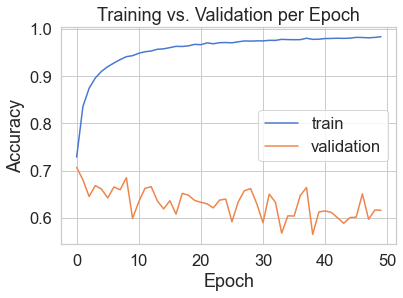

In [112]:
plot_history(model_name, event, save=False)

1602255287-a1ac8d6


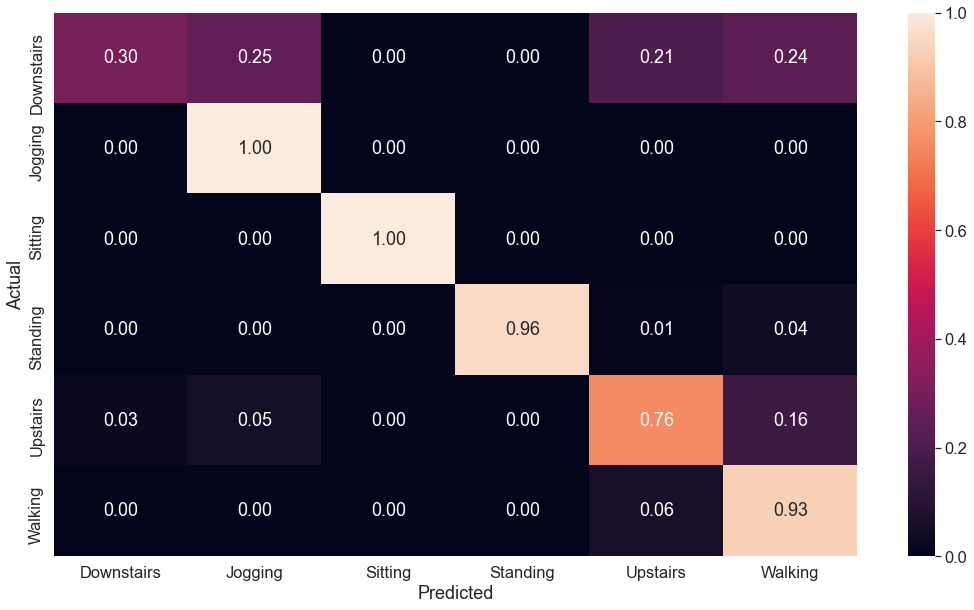

In [97]:
plot_confusion_matrix(
        model_name,
        enc.inverse_transform(y_test),
        enc.inverse_transform(y_pred),
        enc.categories_[0], 
        save=False
    )

1602255287-a1ac8d6


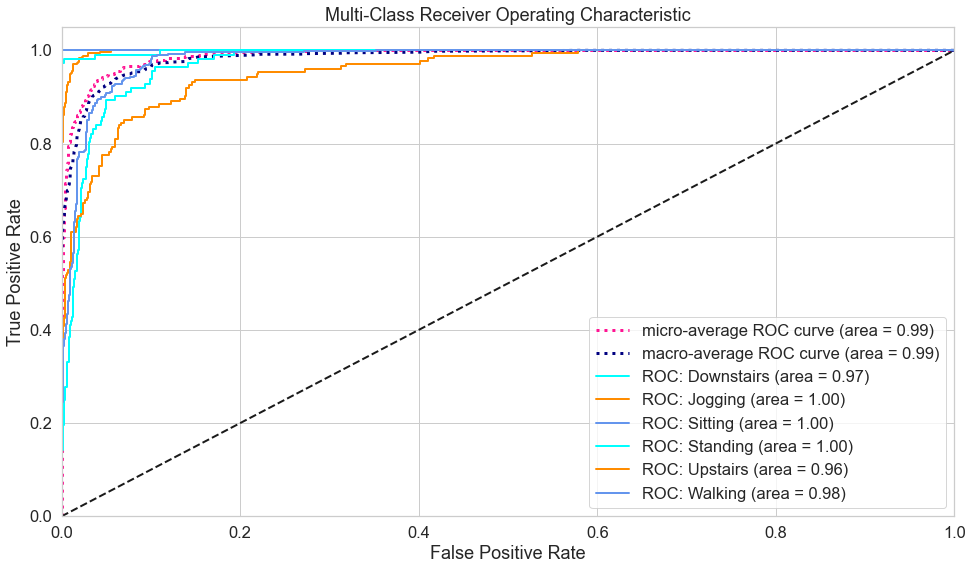

In [98]:
plot_multiROC(model_name, model, X_test, y_test, enc, save=False)

## Comparison to baseline models other approaches

The results above are at least comparable to other experimental results by [Jennifer R. Kwapisz et al 2010](https://www.cis.fordham.edu/wisdm/includes/files/sensorKDD-2010.pdf) where their best reported model of an MLP achieved acc ~ 91%. With notablly better confusion matrix on our part. See tables below:

<img src="images/wisdm-2010-table2.png" height=40% width=40%>

<img src="images/wisdm-2010-table5.png" height=40% width=40%>

Another piece of work that is work comparing against is the analysis done by Jason Brownlee found [here](https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/)

The scope of that analysis was to evaluate deep learning methods for a similiar HAR dataset, namely the [Human Activity Recognition Using Smartphones Data Set, UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones)

> The raw data is not available. Instead, a pre-processed version of the dataset was made available. The pre-processing steps included:

> Pre-processing accelerometer and gyroscope using noise filters.
Splitting data into fixed windows of 2.56 seconds (128 data points) with 50% overlap.Splitting of accelerometer data into gravitational (total) and body motion components.
Feature engineering was applied to the window data, and a copy of the data with these engineered features was made available.

> A number of time and frequency features commonly used in the field of human activity recognition were extracted from each window. The result was a 561 element vector of features.

> The dataset was split into train (70%) and test (30%) sets based on data for subjects, e.g. 21 subjects for train and nine for test.

> Experiment results with a support vector machine intended for use on a smartphone (e.g. fixed-point arithmetic) resulted in a predictive accuracy of 89% on the test dataset, achieving similar results as an unmodified SVM implementation.

Jason Brownlee was able to get results on the order of ~ 90% for:
- LSTM --> Accuracy: 89.722% (+/-1.371)
- CNN+LSTM --> Accuracy: 90.689% (+/-1.051)
- ConvLSTM --> Accuracy: 90.801% (+/-0.886)

## References

#### Papers:


#### Weblinks:

* [The llustrated Transformer](http://jalammar.github.io/illustrated-transformer/)


#### TODO

   1. Implement a custom callback
   2. ~~Compare LSTM of blog post~~
   3. Put code into t2 files
   4. Explain dimensions, give examples. Windowing etc. use TF time_series.ipynb notebooks as example
       - Build WindowGenerator, time_series.ipynb notebook for examples
   5. Give in-depth explaination to adaption for time-series with relation to Transformer achitecture, use http://nlp.seas.harvard.edu/2018/04/03/attention.html and https://srome.github.io/Understanding-Attention-in-Neural-Networks-Mathematically/ as well as http://jalammar.github.io/illustrated-transformer/ and https://github.com/curiousily/Deep-Learning-For-Hackers/blob/master/13.time-series-human_activity_recognition.ipynb as reference
   6. Add table of contents to this notebook